# 🍾 **Supermarket Good Seed- Age Prediction**

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.<br>
The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.<br>
Computer vision methods can be used to determine age of a person from a photo.
The task is to build and evaluate a model for verifying people's age.</div>

## 🚀 Initialization

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression

from tqdm.auto import tqdm

from PIL import Image

from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 🗂️ Load Data

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.<div/>

In [3]:
#Load dataset

labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)


train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw', # 'raw' for regression tasks
    seed=12345,
    subset='training'
)

val_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw', # 'raw' for regression tasks
    seed=12345,
    subset='validation')

features, target = next(train_datagen_flow)
print(features[0])

Found 5694 validated image filenames.
Found 1897 validated image filenames.
[[[0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  ...
  [0.19607845 0.1764706  0.10196079]
  [0.18823531 0.16862746 0.09411766]
  [0.21176472 0.19215688 0.11764707]]

 [[0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  ...
  [0.18431373 0.16078432 0.10588236]
  [0.22352943 0.20000002 0.14509805]
  [0.21176472 0.18823531 0.13333334]]

 [[0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  ...
  [0.16078432 0.12156864 0.1137255 ]
  [0.18039216 0.14117648 0.13333334]
  [0.17254902 0.13333334 0.1254902 ]]

 ...

 [[0.46274513 0.45882356 0.4431373 ]
  [0.46274513 0.45882356 0.4431373 ]
  [0.4666667  0.46274513 0.44705886]
  ...
  [0.6901961  0.6666667  0.6745098 ]
  [0.58431375 0.5411765  0.53333336]
  [0.54509807 0.4784314  0.45098042]]

## **🔭 Exploratory Data Analysis**


<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ Understanding the data structure for model input
</div>

In [14]:
# Check shape and types of features and target arrays that a single batch from the `ImageDataGenerator` provides

print('Shape of image batch (features):', features.shape)
print('Data type of image batch (features):', features.dtype)
print('Shape of age batch (target):', target.shape)
print('Data type of age batch (target):', target.dtype)

print('\nShape of a single image:', features[0].shape)
print('Pixel value range (min, max):', features[0].min(), features[0].max())

Shape of image batch (features): (16, 150, 150, 3)
Data type of image batch (features): float32
Shape of age batch (target): (16,)
Data type of age batch (target): int64

Shape of a single image: (150, 150, 3)
Pixel value range (min, max): 0.0 1.0


In [15]:
# Check dataset size
print(f'Total dataset size: {labels.shape[0]} samples')


Total dataset size: 7591 samples


In [16]:
# Display labels DataFrame
display(labels.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Age distribution in the dataset:


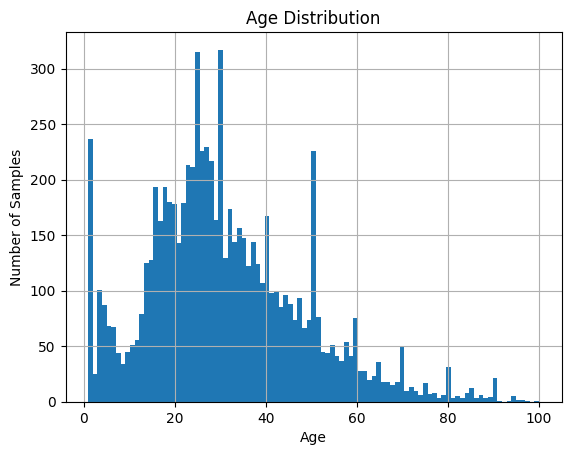

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [17]:
# Explore the age distribution
print('\nAge distribution in the dataset:')
labels['real_age'].hist(bins=labels['real_age'].nunique())
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Samples')
plt.show()

labels['real_age'].describe()



<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 **Age Distribution Analysis**

*   **Total Samples:** The dataset comprises **7591 images**, each associated with a real age.
*   **Age Range:** Ages span from a minimum of **1 year** to a maximum of **100 years**, indicating a very broad spectrum.
*   **Central Tendency:**
    *   The **mean age is approximately 31.20 years**, suggesting a relatively young average age in the dataset.
    *   The **median age (50th percentile) is 29 years**, indicating a slight positive skew that can be observed from the mean being slightly higher than the median.
*   **Dispersion:**
    *   The **standard deviation is 17.14 years**, highlighting a significant spread in ages around the mean.

**Overall Observation:** The histogram visually confirms these statistics, showing a concentration of individuals in younger and middle-aged groups, with a gradual decrease in frequency for older ages. This diverse age representation is ideal for developing a model that can generalize across different life stages.</div>



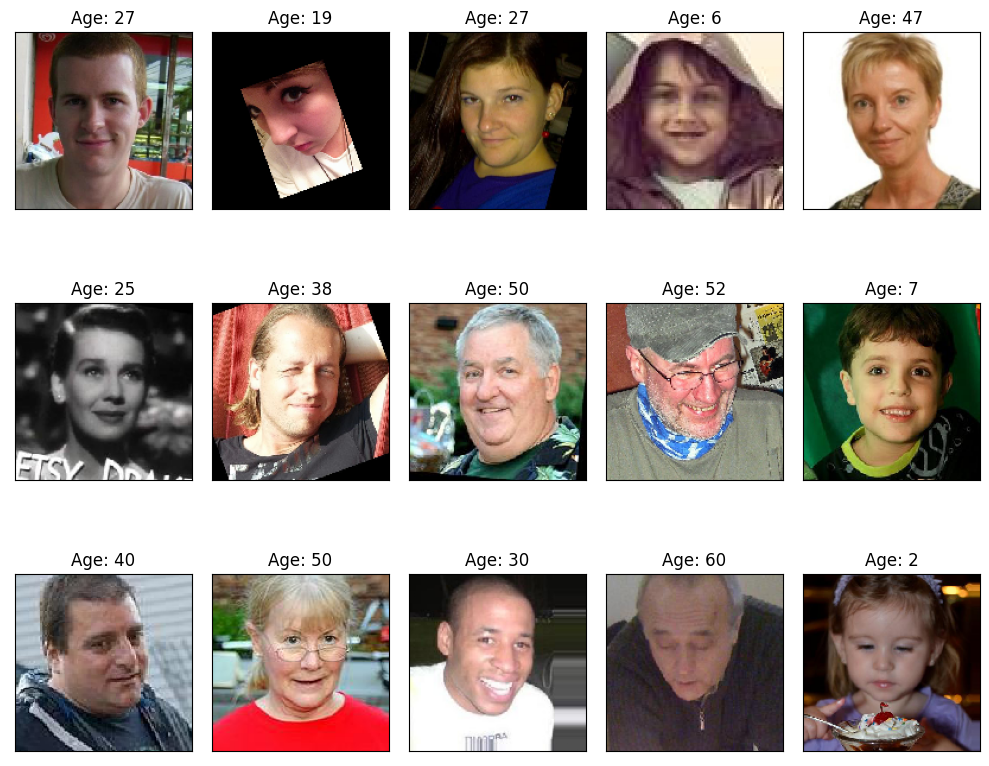

In [18]:
# Print 15 photos for different ages
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 🔎 **Findings**


- **Dataset Size**: The dataset contains 7591 samples, each representing an image with a corresponding real age.
- **Age Distribution**: The dataset contains a diverse age representation, indicating a range of ages from young children to older adults. This is important for ensuring the model can learn from a diverse age group.
- **Image Samples**: We displayed 15 sample images with their ages, which gives us a visual sense of the dataset.

- **Data Structure for Model Input**:
  - Image data (features) is provided in batches of 16 images.
  - Each image is a NumPy array with a shape of (150, 150, 3), representing a 150x150 pixel image with 3 color channels (RGB)
  - The pixel values are float32 and scaled between 0.0 and 1.0, which is a common preprocessing step for neural networks.
  - Age labels (target) are also provided in batches of 16, as int64 values.

These findings confirm that the data is loaded correctly and is in a suitable format for training a deep learning model. </div>


## Modelling

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.<div/>

In [4]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
   
    train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.25)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow


In [6]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_gen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow


In [7]:

def create_model(input_shape):
    
    """
    It defines the model
    """
  
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


In [8]:

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


## Prepare the Script to Run on the GPU Platform

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.<div/>

In [9]:


# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    f.write("""if __name__ == "__main__":
    train_data = load_train("/datasets/faces/")
    test_data = load_test("/datasets/faces/")

    sample_batch = next(train_data)
    input_shape = sample_batch[0].shape[1:]  
    
    model = create_model(input_shape)
    model = train_model(model, train_data, test_data)
    loss, acc = model.evaluate(test_data, verbose=2)
    print("Model accuracy: {:5.2f}%".format(100 * acc))
    """)
    



### Output

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
⬇️ Below we place the output from model we train on a GPU platform. <div/>

Found 5694 validated image filenames.<br>
Found 1897 validated image filenames.<br>
Epoch 1/20<br>
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.<br>
  self._warn_if_super_not_called()<br>
356/356 - 105s - 295ms/step - loss: 221.7489 - mae: 11.2091 - val_loss: 393.5248 - val_mae: 14.8767<br>
Epoch 2/20<br>
356/356 - 18s - 50ms/step - loss: 137.9334 - mae: 8.9025 - val_loss: 194.6651 - val_mae: 10.6882<br>
Epoch 3/20<br>
356/356 - 18s - 49ms/step - loss: 115.0659 - mae: 8.1829 - val_loss: 125.1958 - val_mae: 8.5658<br>
Epoch 4/20<br>
356/356 - 18s - 49ms/step - loss: 98.0420 - mae: 7.4982 - val_loss: 157.0119 - val_mae: 9.3721<br>
Epoch 5/20<br>
356/356 - 18s - 49ms/step - loss: 80.4077 - mae: 6.8333 - val_loss: 195.4510 - val_mae: 10.3372<br>
Epoch 6/20<br>
356/356 - 18s - 50ms/step - loss: 72.9949 - mae: 6.5226 - val_loss: 177.2193 - val_mae: 9.8457<br>
Epoch 7/20<br>
356/356 - 18s - 49ms/step - loss: 60.6089 - mae: 5.9620 - val_loss: 107.6254 - val_mae: 7.7317<br>
Epoch 8/20<br>
356/356 - 18s - 49ms/step - loss: 55.3739 - mae: 5.7020 - val_loss: 105.0810 - val_mae: 7.8732<br>
Epoch 9/20<br>
356/356 - 18s - 50ms/step - loss: 45.9113 - mae: 5.2226 - val_loss: 149.5221 - val_mae: 9.0455<br>
Epoch 10/20<br>
356/356 - 18s - 51ms/step - loss: 40.6983 - mae: 4.8930 - val_loss: 93.6052 - val_mae: 7.3101<br>
Epoch 11/20<br>
356/356 - 18s - 50ms/step - loss: 34.1972 - mae: 4.4918 - val_loss: 87.7219 - val_mae: 7.0117<br>
Epoch 12/20<br>
356/356 - 18s - 50ms/step - loss: 32.2765 - mae: 4.3695 - val_loss: 103.4668 - val_mae: 7.8678<br>
Epoch 13/20<br>
356/356 - 18s - 50ms/step - loss: 28.6810 - mae: 4.1475 - val_loss: 95.1698 - val_mae: 7.1795<br>
Epoch 14/20<br>
356/356 - 17s - 49ms/step - loss: 28.8200 - mae: 4.1151 - val_loss: 85.7164 - val_mae: 7.0293<br>
Epoch 15/20<br>
356/356 - 18s - 49ms/step - loss: 27.3829 - mae: 4.0285 - val_loss: 105.4852 - val_mae: 7.9737<br>
Epoch 16/20<br>
356/356 - 18s - 50ms/step - loss: 25.8413 - mae: 3.9104 - val_loss: 87.1489 - val_mae: 7.1043<br>
Epoch 17/20<br>
356/356 - 18s - 50ms/step - loss: 23.9493 - mae: 3.7614 - val_loss: 89.8479 - val_mae: 7.1393<br>
Epoch 18/20<br>
356/356 - 18s - 50ms/step - loss: 22.0066 - mae: 3.5762 - val_loss: 87.7287 - val_mae: 7.1811<br>
Epoch 19/20<br>
356/356 - 18s - 50ms/step - loss: 20.0573 - mae: 3.4393 - val_loss: 102.4834 - val_mae: 7.9243<br>
Epoch 20/20<br>
356/356 - 17s - 49ms/step - loss: 19.6706 - mae: 3.3767 - val_loss: 84.2094 - val_mae: 6.9743<br>
119/119 - 4s - 36ms/step - loss: 84.2095 - mae: 6.9743<br>
Model accuracy: 697.43%<br>

In [10]:
#Convert output text into a DataFrame for analysis and plotting

import re


# Training output as a string (from cell 29)
training_output = """
Epoch 1/20 - 356/356 - 105s - 295ms/step - loss: 221.7489 - mae: 11.2091 - val_loss: 393.5248 - val_mae: 14.8767<br>
Epoch 2/20 - 356/356 - 18s - 50ms/step - loss: 137.9334 - mae: 8.9025 - val_loss: 194.6651 - val_mae: 10.6882<br>
Epoch 3/20 - 356/356 - 18s - 49ms/step - loss: 115.0659 - mae: 8.1829 - val_loss: 125.1958 - val_mae: 8.5658<br>
Epoch 4/20 - 356/356 - 18s - 49ms/step - loss: 98.0420 - mae: 7.4982 - val_loss: 157.0119 - val_mae: 9.3721<br>
Epoch 5/20 - 356/356 - 18s - 49ms/step - loss: 80.4077 - mae: 6.8333 - val_loss: 195.4510 - val_mae: 10.3372<br>
Epoch 6/20 - 356/356 - 18s - 50ms/step - loss: 72.9949 - mae: 6.5226 - val_loss: 177.2193 - val_mae: 9.8457<br>
Epoch 7/20 - 356/356 - 18s - 49ms/step - loss: 60.6089 - mae: 5.9620 - val_loss: 107.6254 - val_mae: 7.7317<br>
Epoch 8/20 - 356/356 - 18s - 49ms/step - loss: 55.3739 - mae: 5.7020 - val_loss: 105.0810 - val_mae: 7.8732<br>
Epoch 9/20 - 356/356 - 18s - 50ms/step - loss: 45.9113 - mae: 5.2226 - val_loss: 149.5221 - val_mae: 9.0455<br>
Epoch 10/20 - 356/356 - 18s - 51ms/step - loss: 40.6983 - mae: 4.8930 - val_loss: 93.6052 - val_mae: 7.3101<br>
Epoch 11/20 - 356/356 - 18s - 50ms/step - loss: 34.1972 - mae: 4.4918 - val_loss: 87.7219 - val_mae: 7.0117<br>
Epoch 12/20 - 356/356 - 18s - 50ms/step - loss: 32.2765 - mae: 4.3695 - val_loss: 103.4668 - val_mae: 7.8678<br>
Epoch 13/20 - 356/356 - 18s - 50ms/step - loss: 28.6810 - mae: 4.1475 - val_loss: 95.1698 - val_mae: 7.1795<br>
Epoch 14/20 - 356/356 - 17s - 49ms/step - loss: 28.8200 - mae: 4.1151 - val_loss: 85.7164 - val_mae: 7.0293<br>
Epoch 15/20 - 356/356 - 18s - 49ms/step - loss: 27.3829 - mae: 4.0285 - val_loss: 105.4852 - val_mae: 7.9737<br>
Epoch 16/20 - 356/356 - 18s - 50ms/step - loss: 25.8413 - mae: 3.9104 - val_loss: 87.1489 - val_mae: 7.1043<br>
Epoch 17/20 - 356/356 - 18s - 50ms/step - loss: 23.9493 - mae: 3.7614 - val_loss: 89.8479 - val_mae: 7.1393<br>
Epoch 18/20 - 356/356 - 18s - 50ms/step - loss: 22.0066 - mae: 3.5762 - val_loss: 87.7287 - val_mae: 7.1811<br>
Epoch 19/20 - 356/356 - 18s - 50ms/step - loss: 20.0573 - mae: 3.4393 - val_loss: 102.4834 - val_mae: 7.9243<br>
Epoch 20/20 - 356/356 - 17s - 49ms/step - loss: 19.6706 - mae: 3.3767 - val_loss: 84.2094 - val_mae: 6.9743<br>
"""
# Clean the training output and split into lines
training_output_clean = training_output.replace('<br>', '').strip()
lines = training_output_clean.split('\n')

# Initialize lists to store the data
epochs = []
train_loss = []
train_mae = []
val_loss = []
val_mae = []

# Parse each line
for line in lines:
    line = line.strip()
    if line and 'Epoch' in line:
        # Extract epoch number
        epoch_match = re.search(r'Epoch (\d+)/20', line)
        # Extract metrics
        loss_match = re.search(r'loss: ([\d.]+)', line)
        mae_match = re.search(r'mae: ([\d.]+)', line)
        val_loss_match = re.search(r'val_loss: ([\d.]+)', line)
        val_mae_match = re.search(r'val_mae: ([\d.]+)', line)
        
        # If all matches found, add to lists
        if all([epoch_match, loss_match, mae_match, val_loss_match, val_mae_match]):
            epochs.append(int(epoch_match.group(1)))
            train_loss.append(float(loss_match.group(1)))
            train_mae.append(float(mae_match.group(1)))
            val_loss.append(float(val_loss_match.group(1)))
            val_mae.append(float(val_mae_match.group(1)))

# Create DataFrame
training_df_gc = pd.DataFrame({
    'epoch': epochs,
    'train_loss': train_loss,
    'train_mae': train_mae,
    'val_loss': val_loss,
    'val_mae': val_mae
})

In [11]:
# Calculate gaps between train and test set to undesrtand overfitting
training_df_gc['gap_loss']= abs(training_df_gc['train_loss'] - training_df_gc['val_loss'])
training_df_gc['gap_mae']= abs(training_df_gc['train_mae'] - training_df_gc['val_mae'])
# Set epoch as index 
training_df_gc = training_df_gc.set_index('epoch')
print("Training DataFrame:")
training_df_gc

Training DataFrame:


,train_loss,train_mae,val_loss,val_mae,gap_loss,gap_mae
epoch,,,,,,
1,221.7489,11.2091,393.5248,14.8767,171.7759,3.6676
2,137.9334,8.9025,194.6651,10.6882,56.7317,1.7857
3,115.0659,8.1829,125.1958,8.5658,10.1299,0.3829
4,98.0420,7.4982,157.0119,9.3721,58.9699,1.8739
5,80.4077,6.8333,195.4510,10.3372,115.0433,3.5039
6,72.9949,6.5226,177.2193,9.8457,104.2244,3.3231
7,60.6089,5.9620,107.6254,7.7317,47.0165,1.7697
8,55.3739,5.7020,105.0810,7.8732,49.7071,2.1712
9,45.9113,5.2226,149.5221,9.0455,103.6108,3.8229


In [12]:
#Find the epoch number with the best mae (lower)
best_epoch = training_df_gc['val_mae'].idxmin()
print(f"Best epoch (lowest val_mae): {best_epoch}")

# Get the actual value
best_val_mae = training_df_gc.loc[best_epoch, 'val_mae']
print(f"Best val_mae: {best_val_mae} at epoch {best_epoch}")

Best epoch (lowest val_mae): 20
Best val_mae: 6.9743 at epoch 20


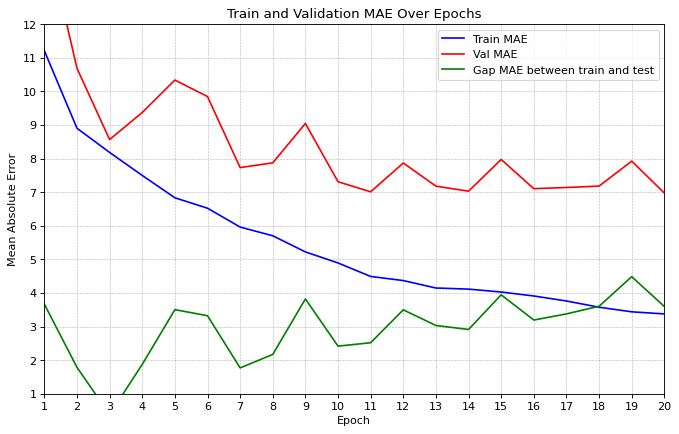

In [13]:
# Plot the distribution of metrics over epochs

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(training_df_gc['train_mae'], label='Train MAE', color='blue')
plt.plot(training_df_gc['val_mae'], label='Val MAE', color='red')
plt.plot(training_df_gc['gap_mae'], label='Gap MAE between train and test', color='green')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Train and Validation MAE Over Epochs')

plt.xticks(range(1, 21))  
plt.xlim(1, 20) 
plt.yticks(range(1, 13))  
plt.ylim(1, 12) 

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Conclusions

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

Based on the training output for 20 epochs we run on a GPU, we can draw the following conclusions regarding the age prediction model:

*  **Loss and MAE Trends:**
   *  The **training loss (MSE)** consistently decreased from `221.7489` in Epoch 1 to `19.6706` in Epoch 20. Similarly, the **training MAE** decreased from `11.2091` to `3.3767`.
   *  The **validation loss (val_loss)** and **validation MAE (val_mae)** showed fluctuations but generally followed a decreasing trend, indicating that the model was learning and generalizing.<br><br>

*  **Model Performance (MAE):**
   *  The primary metric for evaluation, **Mean Absolute Error (MAE) on the validation set**, reached its lowest point at `6.9743` in **Epoch 20**.
   *  The model achieved a `val_mae` **below 8.0**. This result complies with the project's requirement to achieve a Mean Absolute Error score of no more than 8. <br><br>

*  **Overfitting Observation:**
   *  While both training and validation metrics generally improved, there's a increasing gap between training MAE and validation MAE, with training MAE being significantly lower. This suggests some degree of **overfitting** as the model performs much better on the training data than on unseen validation data.<br><br>

*  **Potential Improvements:**
   *  **Learning Rate Scheduling:** Adjusting the learning rate during training could help the model converge more effectively and potentially achieve a lower MAE.
   *  **Data Augmentation:** While `horizontal_flip` was used, further augmentation techniques could improve generalization.
   *  **Hyperparameter Tuning:** Further tuning of batch size, optimizer, and learning rate could yield better results.<br><br>

Overall, the model demonstrates performance with a validation MAE outside acceptable limits, beacuse it is not predicting age well enough to comply with alcohol laws. An average gap of 6-7 years does not guarantee that the supermarket can correctly identify who can buy alcohol using this model. Future work could focus on mitigating overfitting and further improving generalization to achieve more accurate predictions.<br><br>
However, the model may be used to solve other practical tasks. By improving the model perfomance, the client could use the model for marketing segmentation purposes at checkout, such as real-time cross-selling. <div/>
